# Bowyer Watson Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

In [2]:
def generate_random_points(n_points=50, x_range=(0, 1), y_range=(0, 1), seed=None):
    if seed is not None:
        np.random.seed(seed)

    x = np.random.uniform(x_range[0], x_range[1], n_points)
    y = np.random.uniform(y_range[0], y_range[1], n_points)
    
    points = np.column_stack((x, y))
    return points

def generate_gaussian_points(n_points=50, mean=(0.5, 0.5), cov=None, seed=None):
    """2D Gaussian distributed points."""
    if seed is not None:
        np.random.seed(seed)
    if cov is None:
        cov = [[0.02, 0.0], [0.0, 0.02]]  # isotropic default covariance
    points = np.random.multivariate_normal(mean, cov, n_points)
    return np.clip(points, 0, 1)  # keep in [0,1] range


def generate_poisson_disc_points(radius=0.2, x_range=(0, 1), y_range=(0, 1), k=30, seed=None):
    """
    Poisson disk sampling (Blue noise).
    - radius: minimum distance between points.
    - k: number of candidates per active point.
    """
    if seed is not None:
        np.random.seed(seed)

    width, height = x_range[1] - x_range[0], y_range[1] - y_range[0]
    cell_size = radius / np.sqrt(2)
    grid_w, grid_h = int(np.ceil(width / cell_size)), int(np.ceil(height / cell_size))
    grid = -np.ones((grid_h, grid_w), dtype=int)
    points = []
    active_list = []

    def in_bounds(p):
        return x_range[0] <= p[0] <= x_range[1] and y_range[0] <= p[1] <= y_range[1]

    def grid_coords(p):
        return int((p[0] - x_range[0]) / cell_size), int((p[1] - y_range[0]) / cell_size)

    def too_close(p):
        gx, gy = grid_coords(p)
        for i in range(max(gy - 2, 0), min(gy + 3, grid_h)):
            for j in range(max(gx - 2, 0), min(gx + 3, grid_w)):
                idx = grid[i, j]
                if idx != -1:
                    dist = np.linalg.norm(points[idx] - p)
                    if dist < radius:
                        return True
        return False

    # Initial point
    first_point = np.array([
        np.random.uniform(x_range[0], x_range[1]),
        np.random.uniform(y_range[0], y_range[1])
    ])
    points.append(first_point)
    active_list.append(0)
    gx, gy = grid_coords(first_point)
    grid[gy, gx] = 0

    while active_list:
        idx = np.random.choice(active_list)
        base_point = points[idx]
        found = False
        for _ in range(k):
            theta = np.random.uniform(0, 2 * np.pi)
            r = np.random.uniform(radius, 2 * radius)
            new_point = base_point + np.array([r * np.cos(theta), r * np.sin(theta)])
            if in_bounds(new_point) and not too_close(new_point):
                points.append(new_point)
                gx, gy = grid_coords(new_point)
                grid[gy, gx] = len(points) - 1
                active_list.append(len(points) - 1)
                found = True
                break
        if not found:
            active_list.remove(idx)
    return np.array(points)


def generate_clustered_points(n_points=100, n_clusters=3, x_range=(0, 1), y_range=(0, 1), seed=None):
    """Multiple dense clusters with sparse regions between them."""
    if seed is not None:
        np.random.seed(seed)
    cluster_centers = np.random.uniform([x_range[0], y_range[0]], [x_range[1], y_range[1]], (n_clusters, 2))
    points_per_cluster = n_points // n_clusters
    remainder = n_points % n_clusters
    points = []
    for i, center in enumerate(cluster_centers):
        size = points_per_cluster + (1 if i < remainder else 0)
        cov = np.diag(np.random.uniform(0.001, 0.01, 2))
        cluster = np.random.multivariate_normal(center, cov, size)
        points.append(cluster)
    return np.clip(np.vstack(points), 0, 1)

##### Implementation Code

In [3]:
import numpy as np


def triangulate_bw(points):
    """Bowyer-Watson triangulation implementation.

    points: (n,2) array-like
    returns: (m,3) array of triangles (indices into input points)
    """
    pts = np.asarray(points, dtype=float)
    if pts.ndim != 2 or pts.shape[1] != 2:
        raise ValueError('points must be an (n,2) array')

    n = len(pts)
    if n < 3:
        return np.empty((0, 3), dtype=int)

    # Build a supertriangle that contains all points
    minx, miny = pts.min(axis=0)
    maxx, maxy = pts.max(axis=0)
    dx = maxx - minx
    dy = maxy - miny
    dmax = max(dx, dy)
    midx = (minx + maxx) / 2.0
    midy = (miny + maxy) / 2.0
    p1 = np.array([midx - 20 * dmax, midy - dmax])
    p2 = np.array([midx, midy + 20 * dmax])
    p3 = np.array([midx + 20 * dmax, midy - dmax])
    pts_ext = np.vstack([pts, p1, p2, p3])
    super_idx = (n, n + 1, n + 2)

    def circumcenter_and_r2(a, b, c):
        A = b - a
        B = c - a
        denom = 2.0 * (A[0] * B[1] - A[1] * B[0])
        if abs(denom) < 1e-12:
            return (np.array([np.inf, np.inf]), np.inf)
        a_len = np.dot(A, A)
        b_len = np.dot(B, B)
        ux = a[0] + (B[1] * a_len - A[1] * b_len) / denom
        uy = a[1] + (-B[0] * a_len + A[0] * b_len) / denom
        center = np.array([ux, uy])
        r2 = np.sum((center - a) ** 2)
        return center, r2

    def in_circ(tri, p):
        a = pts_ext[tri[0]]
        b = pts_ext[tri[1]]
        c = pts_ext[tri[2]]
        center, r2 = circumcenter_and_r2(a, b, c)
        if r2 == np.inf:
            return False
        return np.sum((p - center) ** 2) <= r2 + 1e-12

    triangles = [super_idx]

    for i_pt in range(n):
        p = pts_ext[i_pt]
        bad = []
        for tri in triangles:
            if in_circ(tri, p):
                bad.append(tri)
        edge_count = {}
        for tri in bad:
            edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
            for a, b in edges:
                key = (min(a, b), max(a, b))
                edge_count[key] = edge_count.get(key, 0) + 1
        boundary = [e for e, c in edge_count.items() if c == 1]
        triangles = [t for t in triangles if t not in bad]
        for edge in boundary:
            a, b = edge
            triangles.append((a, b, i_pt))

    result = [t for t in triangles if not (t[0] >= n or t[1] >= n or t[2] >= n)]
    return np.array(result, dtype=int)


##### Comparison with SciPy Delaunay Triangulation

Verification with 20 points for each dataset:

Random       - BW:  33 triangles, Scipy:  33 triangles, Match: True
Gaussian     - BW:  30 triangles, Scipy:  30 triangles, Match: True
Clustered    - BW:  30 triangles, Scipy:  30 triangles, Match: True
Poisson      - BW:  34 triangles, Scipy:  34 triangles, Match: True


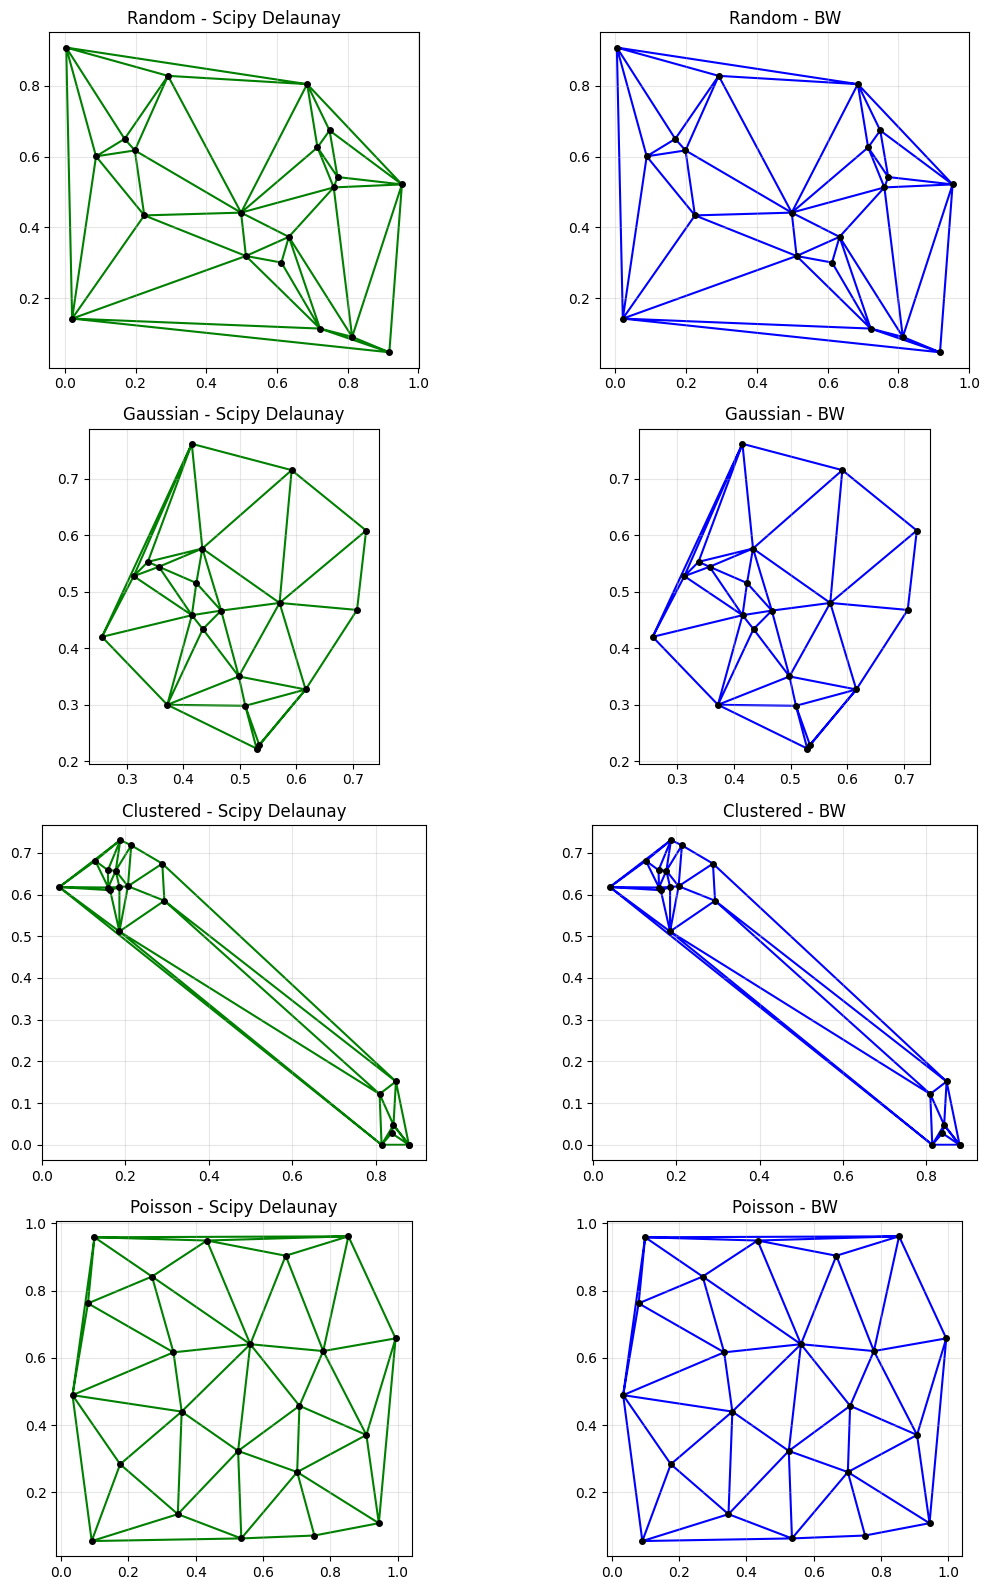

In [6]:
# Verification Step
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np

# 1. Generate Data
n_verify = 20
points_verify = generate_random_points(n_points=n_verify, seed=10)
np.random.shuffle(points_verify)

points_verify_gauss = generate_gaussian_points(n_points=n_verify, seed=42)
np.random.shuffle(points_verify_gauss)

points_verify_clustered = generate_clustered_points(n_points=n_verify, seed=52)
np.random.shuffle(points_verify_clustered)

r = np.sqrt(0.625 / n_verify) 
points_verify_poisson = generate_poisson_disc_points(radius=r, seed=62)
np.random.shuffle(points_verify_poisson)

# 2. Run Flip Algorithm
custom_triangles = triangulate_bw(points_verify)
custom_triangles_gauss = triangulate_bw(points_verify_gauss)
custom_triangles_clustered = triangulate_bw(points_verify_clustered)
custom_triangles_poisson = triangulate_bw(points_verify_poisson)
# 3. Run Scipy Delaunay
delaunay = Delaunay(points_verify)
delaunay_gauss = Delaunay(points_verify_gauss)
delaunay_clustered = Delaunay(points_verify_clustered)
delaunay_poisson = Delaunay(points_verify_poisson)

scipy_simplices = delaunay.simplices
scipy_simplices_gauss = delaunay_gauss.simplices
scipy_simplices_clustered = delaunay_clustered.simplices
scipy_simplices_poisson = delaunay_poisson.simplices

# 4. Compare Results for all datasets
datasets = [
    ("Random", custom_triangles, scipy_simplices, points_verify),
    ("Gaussian", custom_triangles_gauss, scipy_simplices_gauss, points_verify_gauss),
    ("Clustered", custom_triangles_clustered, scipy_simplices_clustered, points_verify_clustered),
    ("Poisson", custom_triangles_poisson, scipy_simplices_poisson, points_verify_poisson)
]

print(f"Verification with {n_verify} points for each dataset:\n")
for name, custom, scipy, _ in datasets:
    custom_set = set(tuple(sorted(t)) for t in custom)
    scipy_set = set(tuple(sorted(t)) for t in scipy)
    is_correct = (custom_set == scipy_set)
    
    print(f"{name:12} - BW: {len(custom_set):3d} triangles, Scipy: {len(scipy_set):3d} triangles, Match: {is_correct}")
    
    if not is_correct:
        print(f"  → In BW only: {custom_set - scipy_set}")
        print(f"  → In Scipy only: {scipy_set - custom_set}")

# 5. Visualize All Datasets in a Grid
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

for idx, (name, custom, scipy, points) in enumerate(datasets):
    # Scipy Plot (left column)
    axes[idx, 0].set_title(f"{name} - Scipy Delaunay")
    if len(scipy) > 0:
        axes[idx, 0].triplot(points[:, 0], points[:, 1], scipy, color='green')
    axes[idx, 0].plot(points[:, 0], points[:, 1], 'ko', markersize=4)
    axes[idx, 0].set_aspect('equal')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # BW Plot (right column)
    axes[idx, 1].set_title(f"{name} - BW")
    if len(custom) > 0:
        axes[idx, 1].triplot(points[:, 0], points[:, 1], custom, color='blue')
    axes[idx, 1].plot(points[:, 0], points[:, 1], 'ko', markersize=4)
    axes[idx, 1].set_aspect('equal')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Dataset Testing

Running for n=250...
Running for n=500...
Running for n=500...
Running for n=750...
Running for n=750...
Running for n=1000...
Running for n=1000...
Running for n=1250...
Running for n=1250...
Running for n=1500...
Running for n=1500...
Running for n=1750...
Running for n=1750...
Running for n=2000...
Running for n=2000...
Running for n=2250...
Running for n=2250...


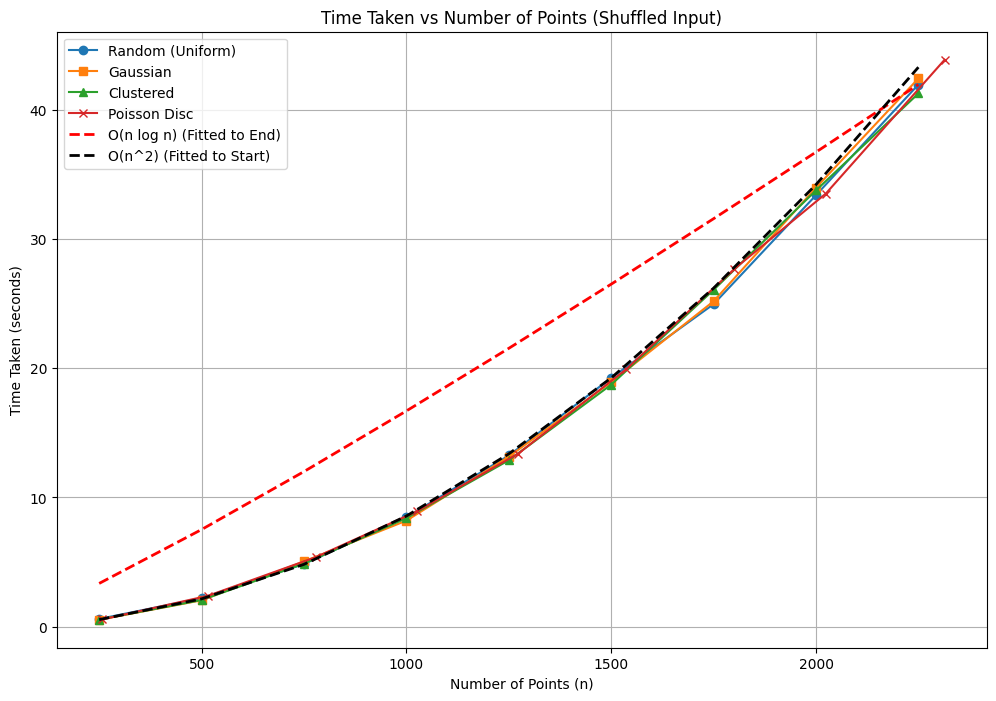

In [8]:
import time
import matplotlib.pyplot as plt
import numpy as np

ns = [i for i in range(250, 2500, 250)]

results = {
    "Random": [],
    "Gaussian": [],
    "Clustered": [],
    "Poisson": []
}

for n in ns:
    print(f"Running for n={n}...")
    
    # Random
    pts = generate_random_points(n_points=n, seed=10)
    np.random.shuffle(pts)
    start_time = time.time()
    triangulate_bw(pts)
    end_time = time.time()
    results["Random"].append(end_time - start_time)
    
    # Gaussian
    pts = generate_gaussian_points(n_points=n, seed=42)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    triangulate_bw(pts)
    end_time = time.time()
    results["Gaussian"].append(end_time - start_time)
    
    # Clustered
    pts = generate_clustered_points(n_points=n, seed=52)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    triangulate_bw(pts)
    end_time = time.time()
    results["Clustered"].append(end_time - start_time)
    
    # Poisson
    r = np.sqrt(0.625 / n) 
    pts = generate_poisson_disc_points(radius=r, seed=62)
    np.random.shuffle(pts) # Shuffle to remove input order bias
    start_time = time.time()
    triangulate_bw(pts)
    end_time = time.time()
    results["Poisson"].append((len(pts), end_time - start_time))

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(ns, results["Random"], label="Random (Uniform)", marker='o')
plt.plot(ns, results["Gaussian"], label="Gaussian", marker='s')
plt.plot(ns, results["Clustered"], label="Clustered", marker='^')

# Poisson scatter/line
p_ns = [x[0] for x in results["Poisson"]]
p_times = [x[1] for x in results["Poisson"]]

# Sort by n (just in case)
p_sorted = sorted(zip(p_ns, p_times))
p_ns = [x[0] for x in p_sorted]
p_times = [x[1] for x in p_sorted]

plt.plot(p_ns, p_times, label="Poisson Disc", marker='x')

# Theoretical Lines
ns_arr = np.array(ns)

# Use the maximum time from Random as a reference for scaling
# We use the last point to anchor the theoretical curves
if results["Random"]:
    # 1. Fit O(n log n) to the LAST point (Max N)
    # This checks: "Does my data follow this shape?"
    ref_n_last = ns[-1]
    ref_time_last = results["Random"][-1]
    
    k_log = ref_time_last / (ref_n_last * np.log(ref_n_last))
    plt.plot(ns, k_log * (ns_arr * np.log(ns_arr)), 'r--', label="O(n log n) (Fitted to End)", linewidth=2)

    # 2. Fit O(n^2) to an EARLY point (e.g., the 5th point)
    # This checks: "If this were quadratic, where would it be by now?"
    # We skip index 0-4 to avoid initial startup noise/caching jitter
    ref_idx = 5 
    if len(ns) > ref_idx:
        ref_n_early = ns[ref_idx]
        ref_time_early = results["Random"][ref_idx]
        k2 = ref_time_early / (ref_n_early**2)
        plt.plot(ns, k2 * (ns_arr**2), 'k--', label="O(n^2) (Fitted to Start)", linewidth=2)

plt.xlabel("Number of Points (n)")
plt.ylabel("Time Taken (seconds)")
plt.title("Time Taken vs Number of Points (Shuffled Input)")
plt.legend()
plt.grid(True)
plt.show()